In [1]:
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [2]:
import pandas as pd
import numpy as np
import glob, os
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.metrics import AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as pyplot

In [93]:
test_dirs = [
    "../demarkindicators/backtest/backtests/results/test_results/EURUSD/ALL/EURUSD60/",
    "../demarkindicators/backtest/backtests/results/test_results/EURGBP/ALL/EURGBP60/"
    "../demarkindicators/backtest/backtests/results/test_results/AUDUSD/ALL/AUDUSD60/",
    "../demarkindicators/backtest/backtests/results/test_results/GBPUSD/ALL/GBPUSD60/",
    "../demarkindicators/backtest/backtests/results/test_results/USDCAD/ALL/USDCAD60/",
    "../demarkindicators/backtest/backtests/results/test_results/USDCHF/ALL/USDCHF60/"
]

In [94]:
file_id_list = [
        (os.path.dirname(filename), int(os.path.basename(filename).split(".")[0]))
        for test_dir in test_dirs
        for filename in glob.glob(test_dir + "*.csv") 
        
    ]
file_id_list = sorted(file_id_list, key=lambda tup: tup[1])

In [95]:
data_files, label_files = [], []

for path, file_id in file_id_list:
    data_files.append(os.path.join(path, str(file_id)) + ".csv")
    label_files.append(os.path.join(path, str(file_id)) + ".meta")


In [96]:
print(data_files[0])
print(label_files[0])

../demarkindicators/backtest/backtests/results/test_results/EURUSD/ALL/EURUSD60/1420588800.csv
../demarkindicators/backtest/backtests/results/test_results/EURUSD/ALL/EURUSD60/1420588800.meta


In [97]:
#input_data = []
#for i,datafile in enumerate(data_files):
#    data = np.genfromtxt(datafile, delimiter=',',skip_header=1 )
#    input_data.append(data)

input_dfs = []
for i,datafile in enumerate(data_files):
    data = pd.read_csv(datafile)
    input_dfs.append(data.fillna(0))

In [98]:
input_dfs[0].head()

,opens,highs,lows,closes,volumes,RSI,ADX,PLUS_DI,MINUS_DI,ATR
0,1.20574,1.20596,1.20491,1.20528,889.0,0.0,0.0,16.389904,35.319987,0.0
1,1.20527,1.20556,1.20461,1.20517,766.0,0.0,0.0,15.940753,33.540166,0.0
2,1.20517,1.20576,1.20486,1.20546,782.0,0.0,0.0,18.029691,29.860112,0.0
3,1.20545,1.20582,1.20351,1.20560,2352.0,0.0,0.0,16.988811,28.136244,0.0
4,1.20563,1.20696,1.20448,1.20474,2662.0,0.0,0.0,18.107841,27.366544,0.0


In [99]:
df_list = [pd.read_csv(filename) for filename in label_files]
all_labels = pd.concat(df_list, ignore_index=True)
all_labels.head()

,profitable,profit_in_pips,instrument,order_type,time,posix_time
0,0,-1758,EURUSD,BUY,2015-01-07 00:00:00,1420588800
1,0,-165,USDCAD,SELL,2015-01-07 00:00:00,1420588800
2,0,-482,USDCHF,SELL,2015-01-07 00:00:00,1420588800
3,0,-676,GBPUSD,BUY,2015-01-08 00:00:00,1420675200
4,0,-442,USDCAD,SELL,2015-01-09 00:00:00,1420761600


In [100]:
buy_indices = all_labels.index[all_labels['order_type'] == "BUY"].tolist()
sell_indices = all_labels.index[all_labels['order_type'] == "SELL"].tolist()
buy_labels = all_labels.loc[all_labels['order_type'] == "BUY"]["profitable"].values
sell_labels = all_labels.loc[all_labels['order_type'] == "SELL"]["profitable"].values
buy_profits = all_labels.loc[all_labels['order_type'] == "BUY"]["profit_in_pips"].values
sell_profits = all_labels.loc[all_labels['order_type'] == "SELL"]["profit_in_pips"].values
buy_inputs = [input_dfs[i] for i in buy_indices]
sell_inputs = [input_dfs[i] for i in sell_indices]

In [101]:
print("% Profitable BUY: {}".format(list(buy_labels).count(1) / len(buy_labels)))
print("% Profitable SELL: {}".format(list(sell_labels).count(1) / len(sell_labels)))

% Profitable BUY: 0.342911877394636
% Profitable SELL: 0.2564102564102564


In [102]:
class MinMaxer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, inputs):
        scaler = MinMaxScaler(feature_range=(0.0001, 1.0))
        for df in inputs:
            df[df.columns] = scaler.fit_transform(df[df.columns])
        return inputs

    def fit(self, inputs):
        pass


In [103]:
class ZeroPad(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, inputs):
        max_len = 0
        for inpd in inputs:
            if len(inpd) > max_len:
                max_len = len(inpd)
        padded_inputs = []
        for inp_df in inputs:
            if len(inp_df) < max_len:
                zeros = [0.0] * (max_len - len(inp_df))
                pad_df = pd.DataFrame(data={k : zeros for k in inp_df.columns})
                padded_inputs.append(pd.concat([inp_df, pad_df]))
            else:
                padded_inputs.append(inp_df)
        
        #inputs = list(map(lambda inp: sequence.pad_sequences(inp, dtype='float32', maxlen=max_len, padding='post'), inputs))
        return padded_inputs

    def fit(self, inputs):
        pass

In [104]:
class ListOfNumpy(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, inputs):
        
        return np.array([inp.to_numpy() for inp in inputs])

    def fit(self, inputs):
        pass

In [105]:
pipe = Pipeline(
            steps=
            [
                ('min_max',MinMaxer()),
                ('zero_pad',ZeroPad()),
                ('list_of_numpy', ListOfNumpy())
            ])

In [106]:
buy_data_pipelined = pipe.transform(buy_inputs)
sell_data_pipelined = pipe.transform(sell_inputs)



In [107]:
buy_data_pipelined.shape

(522, 133, 10)

In [108]:

# Adopt a different train test split strategy that doubles as forward testing.
# -> Find the index whereat 80% of the trades lies before, use that as training.

train_perc = 0.8
buy_stop_index = round(len(buy_labels) * train_perc)
X_buy_train = buy_data_pipelined[:buy_stop_index]
X_buy_test = buy_data_pipelined[buy_stop_index:]
y_buy_train = buy_labels[:buy_stop_index]
y_buy_test = buy_labels[buy_stop_index:]
profit_buy_train = buy_profits[:buy_stop_index]
profit_buy_test = buy_profits[buy_stop_index:]


sell_stop_index = round(len(sell_labels) * train_perc)
X_sell_train = sell_data_pipelined[:sell_stop_index]
X_sell_test = sell_data_pipelined[sell_stop_index:]
y_sell_train = sell_labels[:sell_stop_index]
y_sell_test = sell_labels[sell_stop_index:]
profit_sell_train = buy_profits[:sell_stop_index]
profit_sell_test = buy_profits[sell_stop_index:]


In [109]:
print(X_buy_train.shape)

(418, 133, 10)


In [110]:
X_buy_train.shape[2]

10

In [114]:
def precision_recall(model, X_test: list, y_test: list, profits: list, verbose=True, threshold=0.5) -> tuple:
    true_positives, true_negatives, false_positives, false_negatives = 0, 0, 0, 0
    positives, negatives = list(y_test).count(1), list(y_test).count(0)
    
    print("Analyzing {} samples".format(len(y_test)))
    print("Threshold: {}".format(threshold))
    profit = 0
    for i, (inp, label) in enumerate(zip(X_test, y_test)):
        inp = inp.reshape(1, X_test.shape[1], X_test.shape[2])
        prob_prediction = model.predict([inp], batch_size=1)[0][0]
        class_prediction = model.predict_classes([inp], batch_size=1)[0][0]
        
        
        is_predicted_profitable = True if prob_prediction > threshold else False
        
        if is_predicted_profitable:
            print("Profit: {}".format(profits[i]))
            profit += profits[i]
        
        
        if is_predicted_profitable and label:
            true_positives += 1
        elif not is_predicted_profitable and not label:
            true_negatives += 1
        elif is_predicted_profitable and not label:
            false_positives += 1
        elif not is_predicted_profitable and label:
            false_negatives += 1
            print("False Negative, prob: {}".format(prob_prediction))
        else:
            raise Exception("Error!")
    if not true_positives + false_positives:
        precision = 0
    else:
        precision = true_positives / (true_positives + false_positives)
        
    if not true_positives + false_negatives:
        recall = 0
    else:
        recall = true_positives / (true_positives + false_negatives)
    if verbose:
        print("The model guessed:")
        print("\t{}/{} profitable trades correctly (true positives)".format(true_positives, positives))
        print("\t{}/{} profitable trades incorrectly (false negatives)".format(false_negatives, positives))
        print("\t{}/{} unprofitable trades correctly (true negatives)".format(true_negatives, negatives))
        print("\t{}/{} unprofitable trades incorrectly (false positives)".format(false_positives, negatives))
        print("\t Precision: {}".format(precision))
        print("\t Recall: {}".format(recall))
        print("\t Profit: {}".format(profit))
    return (precision, recall)



# Basic LSTM

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 75)                25800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 76        
Total params: 25,876
Trainable params: 25,876
Non-trainable params: 0
_________________________________________________________________
None
Train on 418 samples
Epoch 1/15
418/418 - 7s - loss: 0.6761 - accuracy: 0.6316
Epoch 2/15
418/418 - 5s - loss: 0.6638 - accuracy: 0.6364
Epoch 3/15
418/418 - 5s - loss: 0.6602 - accuracy: 0.6364
Epoch 4/15
418/418 - 5s - loss: 0.6628 - accuracy: 0.6364
Epoch 5/15
418/418 - 5s - loss: 0.6605 - accuracy: 0.6364
Epoch 6/15
418/418 - 5s - loss: 0.6581 - accuracy: 0.6364
Epoch 

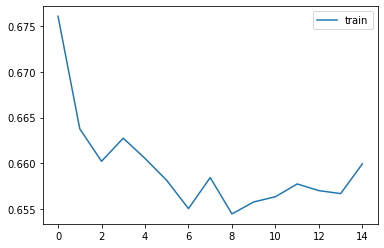

In [116]:
model = Sequential()
model.add(LSTM(75, input_shape=(X_buy_train.shape[1], X_buy_train.shape[2]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_buy_train, y_buy_train, epochs=15, batch_size=16, verbose=2, shuffle=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test') # Only when using validation set
pyplot.legend()

scores = model.evaluate(X_buy_test, y_buy_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [117]:
precision_recall(model, X_buy_test, y_buy_test, profit_buy_test)     

Analyzing 104 samples
Threshold: 0.5
False Negative, prob: 0.371753454208374
False Negative, prob: 0.37175318598747253
False Negative, prob: 0.371753454208374
False Negative, prob: 0.37175312638282776
False Negative, prob: 0.371753454208374
False Negative, prob: 0.3717533349990845
False Negative, prob: 0.371753454208374
False Negative, prob: 0.371753454208374
False Negative, prob: 0.37175339460372925
False Negative, prob: 0.371753454208374
False Negative, prob: 0.371753454208374
False Negative, prob: 0.3717483878135681
False Negative, prob: 0.3717447519302368
False Negative, prob: 0.371753454208374
False Negative, prob: 0.371753454208374
False Negative, prob: 0.37174615263938904
False Negative, prob: 0.37175267934799194
False Negative, prob: 0.3717527985572815
False Negative, prob: 0.3717533051967621
False Negative, prob: 0.3717522919178009
False Negative, prob: 0.371753454208374
False Negative, prob: 0.37175285816192627
False Negative, prob: 0.3717533051967621
False Negative, prob: 0.

(0, 0.0)

# Stacked LSTM

# HyperParameter Tuning for Stacked LSTM

In [91]:
from kerastuner.tuners import RandomSearch


def build_model(hp):
    
    model = Sequential()
    model.add(LSTM(units=hp.Int('units',
                                min_value=32,
                                max_value=256,
                                step=32), 
                   return_sequences=True, input_shape=(X_buy_train.shape[1], X_buy_train.shape[2]), dropout=0.2, recurrent_dropout=0.2))
    
    model.add(Dropout(0.2))
    model.add(LSTM(units=hp.Int('units',
                                min_value=32,
                                max_value=256,
                                step=32), 
                   return_sequences=True))
    
    model.add(Dropout(0.2))
    model.add(LSTM(units=hp.Int('units',
                                min_value=32,
                                max_value=256,
                                step=32), 
                   dropout=0.2, recurrent_dropout=0.2))
    
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(
                                hp.Choice('learning_rate',
                                  values=[1e-2, 1e-3, 1e-4])), 
                  metrics=[binary_accuracy])
    
    
    return model


In [ ]:
tuner = RandomSearch(
    build_model,
    objective='binary_accuracy',
    max_trials=50,
    executions_per_trial=3,
    allow_new_entries=True)

tuner.search_space_summary()
tuner.search(X_buy_train, y_buy_train, epochs=64)

In [ ]:
tuner.results_summary()

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()
precision_recall(best_model, X_buy_test, y_buy_test, profit_buy_test, threshold=0.65)     

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 100)           93600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

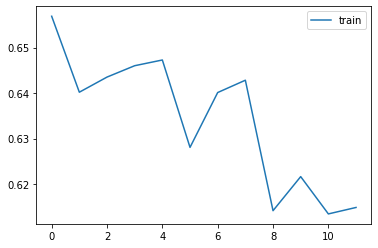

In [63]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_buy_train.shape[1], X_buy_train.shape[2]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_buy_train, y_buy_train, epochs=12, batch_size=16, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test') # Only when using validation set
pyplot.legend()



In [64]:
scores = model.evaluate(X_buy_test, y_buy_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
precision_recall(model, X_buy_test, y_buy_test, profit_buy_test, threshold=0.5)      

Accuracy: 74.04%
Analyzing 104 samples
Threshold: 0.5
False Negative, prob: 0.28536584973335266
False Negative, prob: 0.2250484675168991
False Negative, prob: 0.32086339592933655
False Negative, prob: 0.2570270597934723
False Negative, prob: 0.3253635764122009
False Negative, prob: 0.26355549693107605
False Negative, prob: 0.3442333936691284
False Negative, prob: 0.3148510456085205
False Negative, prob: 0.24505846202373505
False Negative, prob: 0.31949183344841003
False Negative, prob: 0.32762065529823303
Profit: 373
False Negative, prob: 0.2326124757528305
False Negative, prob: 0.3226100206375122
False Negative, prob: 0.33607450127601624
Profit: -241
False Negative, prob: 0.23409084975719452
False Negative, prob: 0.2988980710506439
False Negative, prob: 0.26833420991897583
False Negative, prob: 0.25069698691368103
Profit: 631
False Negative, prob: 0.3206718862056732
False Negative, prob: 0.4092714488506317
Profit: -156
False Negative, prob: 0.24582023918628693
False Negative, prob: 0.

(0.5, 0.07407407407407407)

# Stacked LSTM - Non-Padded Inputs

In [114]:
nonpadded_pipe = Pipeline(
            steps=
            [
                ('min_max',MinMaxer()),
                ('transpose', Transposer())
            ])

In [115]:

buy_data_pipelined_non_padded = nonpadded_pipe.transform(buy_inputs)


train_perc = 0.8
buy_stop_index = round(len(buy_labels) * train_perc)
X_buy_train = buy_data_pipelined_non_padded[:buy_stop_index]
X_buy_test = buy_data_pipelined_non_padded[buy_stop_index:]
y_buy_train = buy_labels[:buy_stop_index]
y_buy_test = buy_labels[buy_stop_index:]
profit_buy_train = buy_profits[:buy_stop_index]
profit_buy_test = buy_profits[buy_stop_index:]

print(len(buy_data_pipelined_non_padded[0][0]))

46


In [116]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(None, X_buy_train.shape[2]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_buy_train, y_buy_train, epochs=12, batch_size=16, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test') # Only when using validation set
pyplot.legend()

AttributeError: 'list' object has no attribute 'shape'

# Bidirectional LSTM

In [112]:
model = Sequential()
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2), input_shape=(X_buy_train.shape[1], X_buy_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_buy_train, y_buy_train, epochs=20, batch_size=16, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test') # Only when using validation set
pyplot.legend()

    

AttributeError: 'list' object has no attribute 'shape'

In [113]:
scores = model.evaluate(X_buy_test, y_buy_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
precision_recall(model, X_buy_test, y_buy_test, profit_buy_test)  

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

# Stacked Bidirectional LSTM

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 10, 200)           181600    
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 200)           240800    
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 200)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)               

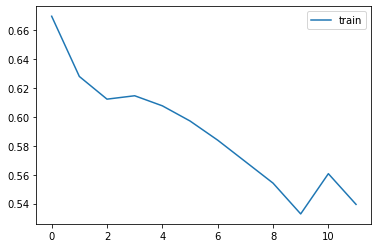

In [297]:
model = Sequential()
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True), input_shape=(X_buy_train.shape[1], X_buy_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_buy_train, y_buy_train, epochs=12, batch_size=16, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test') # Only when using validation set
pyplot.legend()



In [298]:
scores = model.evaluate(X_buy_test, y_buy_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

precision_recall(model, X_buy_test, y_buy_test, profit_buy_test)  

Accuracy: 73.91%
Threshold: 0.5
Profit: -170
Profit: 201
Profit: -161
Profit: 861
Profit: 269
The model guessed:
	3/13 profitable trades correctly (true positives)
	10/13 profitable trades incorrectly (false negatives)
	31/33 unprofitable trades correctly (true negatives)
	2/33 unprofitable trades incorrectly (false positives)
	 Precision: 0.6
	 Recall: 0.23076923076923078
	 Profit: 1000


(0.6, 0.23076923076923078)